# <center>Binary Classification with PyMVA</center>

**PyMVA** is a set of plugins for TMVA package based on Python (SciKit learn) that consist in a set of classes that engage TMVA and allows new methods of classification and regression using by example SciKit’s modules. 

In [1]:
import ROOT

Welcome to JupyROOT 6.14/04


## Settings

Select Theano as backend for Keras

In [2]:
from os import environ
environ['KERAS_BACKEND'] = 'theano'

Set architecture of system

In [3]:
environ['THEANO_FLAGS'] = 'gcc.cxxflags=-march=corei7'

Keras imports

In [4]:
from keras.models import Sequential # Sequential builder
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam

/home/andrea/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using Theano backend.
/home/andrea/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


The **Sequential** API allows you to create models layer-by-layer for most problems. It is limited in that it does not allow you to create models that share layers or have multiple inputs or outputs.

Alternatively, the **Functional** API allows you to create models that have a lot more flexibility as you can easily define models where layers connect to more than just the previous and next layers. In fact, you can connect layers to (literally) any other layer. As a result, creating complex networks such as siamese networks and residual networks become possible.

## Load data

In [5]:
# Open file "inputdata.root" placed in the same directory as this notebook
data = ROOT.TFile.Open("inputdata.root")

# Get signal and background trees from file
signal = data.Get('TreeS')
background = data.Get('TreeB')

# Add variables to dataloader
dataloader = ROOT.TMVA.DataLoader('dataset_pymva')
numVariables = len(signal.GetListOfBranches())

for branch in signal.GetListOfBranches():
    dataloader.AddVariable(branch.GetName())
    
# Add trees to dataloader
dataloader.AddSignalTree(signal, 1.0)
dataloader.AddBackgroundTree(background, 1.0)

trainTestSplit = 0.8
dataloader.PrepareTrainingAndTestTree(ROOT.TCut(''),
                                      'TrainTestSplit_Signal={}:'.format(trainTestSplit)+\
                                      'TrainTestSplit_Background={}:'.format(trainTestSplit)+\
                                      'SplitMode=Random')

DataSetInfo              : [dataset_pymva] : Added class "Signal"
                         : Add Tree TreeS of type Signal with 6000 events
DataSetInfo              : [dataset_pymva] : Added class "Background"
                         : Add Tree TreeB of type Background with 6000 events
                         : Dataset[dataset_pymva] : Class index : 0  name : Signal
                         : Dataset[dataset_pymva] : Class index : 1  name : Background


## Set up TMVA

In [6]:
# Setup TMVA
ROOT.TMVA.Tools.Instance()
ROOT.TMVA.PyMethodBase.PyInitialize()

outputFile = ROOT.TFile.Open('TMVAOutputPyMVA.root', 'RECREATE')
factory = ROOT.TMVA.Factory('TMVAClassification', outputFile,
        '!V:!Silent:Color:DrawProgressBar:Transformations=I,G:'+\
        'AnalysisType=Classification')

## Define model for Keras

**Dense layers:** Regular densely-connected NN layer, a linear stack of layers.

**Dropout**: Applies Dropout to the input. It consists in randomly setting a fraction of input units to 0 at each update during training time, which helps prevent overfitting.

In [7]:
# Define a sequential model
model = Sequential()

# Passing a list of layer instances to the constructor
model.add(Dense(32, activation="relu", kernel_initializer="glorot_normal", input_dim=numVariables))
model.add(Dropout(0.5))
model.add(Dense(32, activation="relu", kernel_initializer="glorot_normal"))
model.add(Dropout(0.5))
model.add(Dense(2, activation="softmax", kernel_initializer="glorot_uniform"))

# Set loss and optimizer
model.compile(loss='categorical_crossentropy', optimizer=Adam(),
        metrics=['categorical_accuracy',])

# Store model to file
model.save('model.h5')

# Print summary of model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                160       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


## Book methods

Just run the cells that contain the classifiers you want to try.

In [8]:
# Keras interface with previously defined model
factory.BookMethod(dataloader, ROOT.TMVA.Types.kPyKeras, 'PyKeras',
        'H:!V:VarTransform=G:FilenameModel=model.h5:'+\
        'NumEpochs=10:BatchSize=32:'+\
        'TriesEarlyStopping=3')

# Gradient tree boosting from scikit-learn package
factory.BookMethod(dataloader, ROOT.TMVA.Types.kPyGTB, 'GTB',
        'H:!V:VarTransform=None:'+\
        'NEstimators=100:LearningRate=0.1:MaxDepth=3')

/home/andrea/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/andrea/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


<ROOT.TMVA::MethodPyGTB object ("GTB") at 0x8e28f50>

Factory                  : Booking method: PyKeras
                         : 
PyKeras                  : [dataset_pymva] : Create Transformation "G" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'var1' <---> Output : variable 'var1'
                         : Input : variable 'var2' <---> Output : variable 'var2'
                         : Input : variable 'var3' <---> Output : variable 'var3'
                         : Input : variable 'var4' <---> Output : variable 'var4'
                         : Load model from file: model.h5
Factory                  : Booking method: GTB
                         : 


## Run training, testing and evaluation

In [9]:
factory.TrainAllMethods()

/home/andrea/anaconda3/lib/python3.5/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 9600 samples, validate on 2400 samples
Epoch 1/10
9600/9600 [==============================] - 1s 58us/step - loss: 0.5921 - categorical_accuracy: 0.6747 - val_loss: 0.4974 - val_categorical_accuracy: 0.7779

Epoch 00001: val_loss improved from inf to 0.49745, saving model to dataset_pymva/weights/TrainedModel_PyKeras.h5
Epoch 2/10
9600/9600 [==============================] - 1s 66us/step - loss: 0.5055 - categorical_accuracy: 0.7520 - val_loss: 0.4342 - val_categorical_accuracy: 0.7925

Epoch 00002: val_loss improved from 0.49745 to 0.43423, saving model to dataset_pymva/weights/TrainedModel_PyKeras.h5
Epoch 3/10
9600/9600 [==============================] - 1s 61us/step - loss: 0.4632 - categorical_accuracy: 0.7748 - val_loss: 0.4035 - val_categorical_accuracy: 0.8225

Epoch 00003: val_loss improved from 0.43423 to 0.40347, saving model to dataset_pymva/weights/TrainedModel_PyKeras.h5
Epoch 4/10
9600/9600 [==============================] - 1s 72us/step - loss: 0.4415 - catego

In [10]:
factory.TestAllMethods()

Factory                  : Test all methods
Factory                  : Test method: PyKeras for Classification performance
                         : 
                         : Load model from file: dataset_pymva/weights/TrainedModel_PyKeras.h5
Factory                  : Test method: GTB for Classification performance
                         : 
                         : 
                         : Loading state file: dataset_pymva/weights/PyGTBModel_GTB.PyData
                         : 


In [11]:
factory.EvaluateAllMethods()

Factory                  : Evaluate all methods
Factory                  : Evaluate classifier: PyKeras
                         : 
TFHandler_PyKeras        : Variable        Mean        RMS   [        Min        Max ]
                         : -----------------------------------------------------------
                         :     var1:   0.021502     1.0002   [    -2.8156     5.7307 ]
                         :     var2:   0.017676     1.0066   [    -2.8597     2.9384 ]
                         :     var3:   0.016944    0.99606   [    -2.9303     3.4026 ]
                         :     var4:   0.014696    0.99725   [    -2.9557     2.8578 ]
                         : -----------------------------------------------------------
PyKeras                  : [dataset_pymva] : Loop over test events and fill histograms with classifier response...
                         : 
TFHandler_PyKeras        : Variable        Mean        RMS   [        Min        Max ]
                         : --

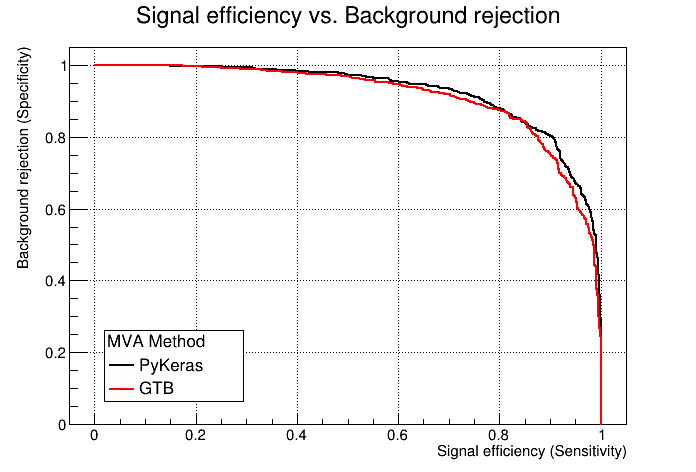

In [12]:
# Print ROC
canvas = factory.GetROCCurve(dataloader)
canvas.Draw()

Both present very good outcomes. PyKeras has a performance slightly better than GTB.